<a href="https://colab.research.google.com/github/Dainn98/GenerativeAI/blob/main/%5BKDN_2024_SV%5D_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook: Mô hình truy xuất thông tin / văn bản (Information/ Documents Retrieval)
![image](https://qa.fastforwardlabs.com/images/copied_from_nb/my_icons/QAworkflow.png)

**Nội dung của Notebook bao gồm:**
1. Xây dựng mô hình truy xuất văn bản miền dữ liệu pháp luật
  - Dựa trên các kĩ thuật học máy truyền thống
  - Dựa trên các mô hình học sâu
2. Xây dựng mô hình truy xuất thông tin miền dữ liệu pháp luật dựa trên các mô hình học sâu


## Giải thích bài toán
Nhu cầu tìm kiếm văn bản, trích xuất thông tin trong miền dữ liệu luật pháp đang ngày một nhiều. Các hệ thống xử lý ngôn ngữ tự nhiên hoạt động trong miền dữ liệu pháp luật tiết kiệm rất nhiều thời gian cho các luật sư hay các chuyên gia trong ngành luật pháp. Không những vậy, các hệ thống truy vấn văn bản pháp luật dựa trên ngữ nghĩa còn giúp mọi người nâng cao nhận thức về pháp luật, giảm thiểu được những trường hợp phạm pháp đáng tiếc. Hai phần dưới đây mô tả hai bài toán điển hình trong lĩnh vực Legal NLP đó là bài toán `Trích xuất văn bản` và bài toán `Trích xuất thông tin`. Đây là hai bài toán quan trọng, đóng vai trò là tiền đề cho các bài toán phức tạp hơn như bài toán Answer Generation hay Textual Entailment.

### 1. Bài toán trích xuất văn bản
Mục tiêu của bài toán này yêu cầu tìm ra những văn bản pháp luật (có trong tập văn bản pháp luật cho trước) liên quan tới câu truy vấn đầu vào. Cụ thể:
- _Input_:
  - Câu truy vấn ($q$)
  - Tập văn bản ($D = {d_1, d_2, ..., d_n}$)
- _Output_:
  - Tập văn bản pháp luật ($D_q \subset D$) có liên quan hoặc có thể dùng để trả lời cho câu truy vấn $q$.

Một số độ đo được sử dụng để đánh giá hiệu quả của hệ truy vấn văn bản cho một truy vấn $q_i$:
- $Precision_i = \frac{\text{số văn bản dự đoán đúng}}{\text{tổng số văn bản thực sự liên quan}}$

- $Recall_i = \frac{\text{số văn bản dự đoán đúng}}{\text{tổng số văn bản mô hình dự đoán là liên quan}}$

- $F2_i = \frac{5 \times Precision_i \times Recall_i}{4Precision_i + Recall_i}$

Điểm đánh giá trên tập test sẽ được đánh giá bằng trung bình tất cả các $F2_i$.

### 2. Bài toán trích xuất thông tin
Mục tiêu của bài toán này không chỉ yêu cầu mô hình tìm ra văn bản pháp luật liên quan mà còn yêu cầu mô hình tìm ra đoạn văn nào trong văn bản đó liên quan trực tiếp tới câu truy vấn. Cụ thể:
- _Input_:
  - Câu truy vấn ($q$)
  - Tập văn bản pháp luật ($D = {d_1, d_2, ..., d_n}$)
- _Output_:
  - Đoạn văn nằm trong 1 văn bản thuộc tập văn bản pháp luật $D$ sao cho đoạn văn đó trực tiếp trả lời cho câu truy vấn $q$.

## Bài toán Trích xuất văn bản pháp luật
Ở phần dưới đây, chúng ta sẽ cùng giải quyết bài toán Trích xuất văn bản pháp luật theo 2 hướng:
- Sử dụng kĩ thuật NLP truyền thống
- Sử dụng kết kĩ thuật truyền thống kết hợp với mô hình học sâu

**\* Câu hỏi: Như đã học các buổi trước, các mô hình học sâu có sức mạnh rất lớn khi tận dụng được thông tin về ngữ nghĩa của dữ liệu văn bản. Tuy nhiên, tại sao không sử dụng trực tiếp mô hình học sâu mà lại phải kết hợp với các kĩ thuật truyền thống ?**

---  
Bộ dữ liệu sẽ sử dụng để thực hành: **ALQAC 2021**

> ALQAC là một workshop về Legal NLP, được tổ chức hàng năm song song với hội nghị quốc tế KSE. Mỗi năm, workshop sẽ đưa ra một bộ dữ liệu và các task để các đội, các nhóm nghiên cứu có thể tranh tài và trao đổi phương pháp.
---

In [ ]:
%%capture
# Import các thư viện cần thiết
from IPython.display import clear_output
! pip install underthesea
! pip install rank-bm25
! pip install lightning
! pip install 'transformers[torch]'
! pip3 install openai
import json
import pandas as pd
from pprint import pprint
!pip install ragatouille
clear_output()

### Đọc - Hiểu cấu trúc dữ liệu đầu vào
---
Mô tả cấu trúc bộ dữ liệu ALQAC 2021


*   File `law.json` tập các văn bản luật

  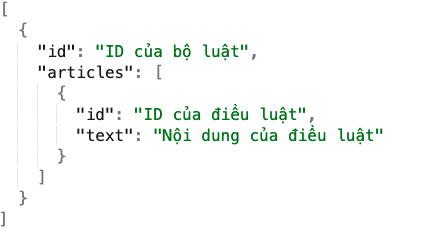


*   File `question.json`: Tập các câu truy vấn và nhãn (tập các văn bản luật liên quan)
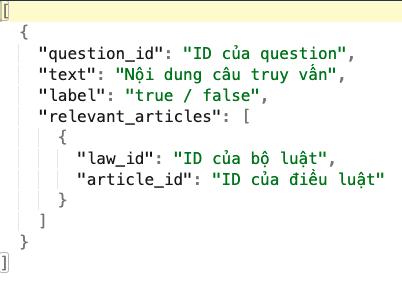


In [ ]:
# Download bộ dữ liệu ALQAC 2022
from IPython.display import clear_output
!gdown --folder --id 1d1kUd8T43P-ltwSvRkGnEZIykiIkIEtQ
clear_output()

# Config các đường dẫn tới các file dữ liệu
LAW_JSON_PATH = "/content/ALQAC 2021/law.json"
QUESTION_JSON_PATH = "/content/ALQAC 2021/question.json"
TEST_JSON_PATH = "/content/ALQAC 2021/ALQAC_test_release.json"

In [ ]:
# Thực hiện đọc các file dữ liệu
with open(LAW_JSON_PATH, 'r', encoding='utf-8') as f:
  law_corpus = json.load(f)

with open(QUESTION_JSON_PATH, 'r', encoding='utf-8') as f:
  data = json.load(f)

with open(TEST_JSON_PATH, 'r', encoding='utf-8') as f:
  test_data = json.load(f)

### Tiền xử lý dữ liệu
---
1. Do bộ dữ liệu hiện tại được phân làm nhiều cấp (Bộ luật rồi mới đến luật). Chính vì vậy, ta cần làm phẳng bộ các văn bản luật.

2. Do dữ liệu đầu vào là Tiếng Việt nên ta sẽ cần thực nghiệm với cả dữ liệu đã được segment để thấy được sự hiệu quả.

\* _Chú ý: Sau mỗi bước tiền xử lý, bộ dữ liệu được tạo ra cần được lưu lại ngay lập tức để tránh việc phải chạy lại một bước tiền xử lý nhiều lần, tiêu tốn nhiều thời gian thừa._

#### Làm phẳng tập các văn bản luật và chỉnh article_id của bộ dữ liệu huấn luyện, kiểm thử

In [ ]:
# Bước 1: Làm phẳng tập các văn bản luật

def combine_new_article_id(law_id, article_id):
  return f"{law_id}|{article_id}"

flat_law_corpus = [
  {
      **dieu_luat,
    "id": combine_new_article_id(bo_luat.get('id'),dieu_luat.get('id'))
  }
  for bo_luat in law_corpus for dieu_luat in bo_luat.get('articles')
]

print("Law corpus sample: ")
pprint(flat_law_corpus[0])

# Chỉnh sửa relevant_article tại các sample cho đúng với format article_id mới
print("-"*10)
update_article_data = [
    {
        **sample,
        "relevant_articles": [
            combine_new_article_id(article.get('law_id'), article.get('article_id'))
            for article in sample.get("relevant_articles")
        ]
    } for sample in data
]

print("Training sample: ")
pprint(update_article_data[0])

print("-"*10)
update_article_test_data = [
    {
        **sample,
        "relevant_articles": [
            combine_new_article_id(article.get('law_id'), article.get('article_id'))
            for article in sample.get("relevant_articles")
        ]
    } for sample in test_data
]
print("Testing sample: ")
pprint(update_article_test_data[0])

# Lưu lại bộ dữ liệu sau khi tiền xử lý bước 1
STAGE_1_LAW_CORPUS_PATH = "/content/ALQAC 2021/stage_1_law.json"
STAGE_1_DATA_PATH = "/content/ALQAC 2021/stage_1_data.json"
STAGE_1_TEST_PATH = "/content/ALQAC 2021/stage_1_test.json"

with open(STAGE_1_LAW_CORPUS_PATH, 'w', encoding='utf-8') as f:
  json.dump(flat_law_corpus, f, ensure_ascii=False)

with open(STAGE_1_DATA_PATH, 'w', encoding='utf-8') as f:
  json.dump(update_article_data, f, ensure_ascii=False)

with open(STAGE_1_TEST_PATH, 'w', encoding='utf-8') as f:
  json.dump(update_article_test_data, f, ensure_ascii=False)

#### Segment nội dung

In [ ]:
# Thực hiện segment với bộ dữ liệu

from underthesea import word_tokenize

with open(STAGE_1_LAW_CORPUS_PATH, 'r', encoding='utf-8') as f:
  stage_1_law_corpus = json.load(f)
  stage_2_law_corpus = [
      {
          **dieu_luat,
          "segment_text": word_tokenize(dieu_luat.get('text'), format="text")
      } for dieu_luat in stage_1_law_corpus
  ]

with open(STAGE_1_DATA_PATH, 'r', encoding='utf-8') as f:
  stage_1_data = json.load(f)
  stage_2_data = [
      {
          **sample,
          "segment_text": word_tokenize(sample.get('text'), format="text")
      }
      for sample in stage_1_data
  ]

with open(STAGE_1_TEST_PATH, 'r', encoding='utf-8') as f:
  stage_1_test_data = json.load(f)
  stage_2_test_data = [
      {
          **sample,
          "segment_text": word_tokenize(sample.get('text'), format="text")
      }
      for sample in stage_1_test_data
  ]

In [ ]:
# In ra một mẫu dữ liệu sau khi đã tiền xử lý

print('Law corpus sample: ')
pprint(stage_2_law_corpus[0])
print('='*10)

print('Data sample: ')
pprint(stage_2_data[0])
print('='*10)

print('Test Data sample: ')
pprint(stage_2_test_data[0])
print('='*10)

Law corpus sample: 
{'id': '45/2019/QH14|1',
 'segment_text': 'Phạm_vi điều_chỉnh Bộ_luật_Lao_động quy_định tiêu_chuẩn '
                 'lao_động ; quyền , nghĩa_vụ , trách_nhiệm của người lao_động '
                 ', người sử_dụng lao_động , tổ_chức đại_diện người lao_động '
                 'tại cơ_sở , tổ_chức đại_diện người sử_dụng lao_động trong '
                 'quan_hệ lao_động và các quan_hệ khác liên_quan trực_tiếp đến '
                 'quan_hệ lao_động ; quản_lý_nhà_nước về lao_động .',
 'text': 'Phạm vi điều chỉnh\n'
         '\n'
         'Bộ luật Lao động quy định tiêu chuẩn lao động; quyền, nghĩa vụ, '
         'trách nhiệm của người lao động, người sử dụng lao động, tổ chức đại '
         'diện người lao động tại cơ sở, tổ chức đại diện người sử dụng lao '
         'động trong quan hệ lao động và các quan hệ khác liên quan trực tiếp '
         'đến quan hệ lao động; quản lý nhà nước về lao động.'}
Data sample: 
{'label': False,
 'question_id': 'q-189',
 'relevant

In [ ]:
# Lưu dữ liệu sau khi đã tiền xử lý

STAGE_2_LAW_CORPUS_PATH = '/content/ALQAC 2021/stage_2_law_corpus.json'
STAGE_2_DATA_PATH = '/content/ALQAC 2021/stage_2_data.json'
STAGE_2_TEST_PATH = '/content/ALQAC 2021/stage_2_test.json'


with open(STAGE_2_LAW_CORPUS_PATH, 'w', encoding='utf-8') as f:
  json.dump(stage_2_law_corpus, f, ensure_ascii=False)

with open(STAGE_2_DATA_PATH, 'w', encoding='utf-8') as f:
  json.dump(stage_2_data, f, ensure_ascii=False)

with open(STAGE_2_TEST_PATH, 'w', encoding='utf-8') as f:
  json.dump(stage_2_test_data, f, ensure_ascii=False)

### Xây dựng hệ truy vấn dựa trên mô hình BM25
---

Trong tìm kiếm thông tin, Okapi BM25 là hàm tính thứ hạng được các hệ thống tìm kiếm sử dụng để xếp hạng các văn bản dựa trên độ liên quan dựa trên mức từ vựng. Hàm xếp hạng này dựa trên mô hình xác suất, được phát minh ra vào những năm 1970 – 1980. Phương pháp có tên BM25 (BM – best match), nhưng người ta thường gọi "Okapi BM25", vì lần đầu tiên công thức được sử dụng trong hệ thống tìm kiếm Okapi, được sáng lập tại trường đại học London những năm 1980 và 1990.

Tham khảo:
- Robertson, Stephen, and Hugo Zaragoza. "The probabilistic relevance framework: BM25 and beyond." Foundations and Trends® in Information Retrieval 3.4 (2009): 333-389.

In [ ]:
# @title Lựa chọn dữ liệu để thực hiện xử lý có segment (segment_text) hoặc không segment (text) + config đường dẫn tới dữ liệu

data_text_field = "text" # @param {type:"string"}

corpus_text_field = "text" # @param {type:"string"}

LAW_CORPUS_PATH = "/content/ALQAC 2021/stage_2_law_corpus.json" # @param {type:"string"}

DATA_PATH = "/content/ALQAC 2021/stage_2_data.json" # @param {type:"string"}

TEST_PATH = "/content/ALQAC 2021/stage_2_test.json" # @param {type:"string"}

#### Dựng mô hình BM25

##### Hàm chức năng

In [ ]:
import numpy as np


def evaluate_sample_recall(given_sample):
  """
  Đánh giá điểm recall-score của một sample
  (dựa vào 2 trường: predict_article và relevant_article)
  """
  assert given_sample["predict_articles"] is not None, "Missing predict_articles"
  assert given_sample["relevant_articles"] is not None, "Missing relevant_articles"
  assert (
      len(given_sample["relevant_articles"]) > 0
  ), "number of relevant articles is 0"
  list_relevant_article = given_sample["relevant_articles"]
  num_relevant = len(list_relevant_article)
  num_true_positive = len(
      [
          _relevant_article
          for _relevant_article in list_relevant_article
          if _relevant_article in given_sample.get("predict_articles")
      ]
  )
  return num_true_positive / num_relevant


def evalute_list_sample_recall(list_sample):
  """
  Đánh giá điểm recall-score của một tập các sample
  (dựa vào 2 trường: predict_article và relevant_article)
  """
  list_recall_score = []
  for sample in list_sample:
    recall_i = evaluate_sample_recall(sample)
    list_recall_score.append(recall_i)
  return sum(list_recall_score) / (len(list_recall_score) + 1e-10)

def find_article_position(given_statute_corpus, given_article_id):
  """
  Tìm vị trí của văn bản dựa trên ID của văn bản đó
  """
  for pos, article in enumerate(given_statute_corpus):
      if article.get("id") == given_article_id:
          return pos
  return None

def add_bm25_to_sample(
    list_data,
    output_file_path,
    _statute_corpus,
    _bm25_model,
    top_n,
    query_field="query",
):
    """
    Thực hiện infer BM25 và ghi kết quả infer vào dữ liệu
    """
    print('Statute corpus length: ', len(_statute_corpus))
    # list_f2_score = []
    n_empty_relevant = 0
    for sample in list_data:
        try:
            list_bm25_score = _bm25_model.get_scores(
                sample.get(data_text_field).split(" ")
            ).tolist()
            list_article_pos = np.argsort(list_bm25_score)[::-1][:top_n].tolist()
            sample["bm25_candidate"] = [
                _statute_corpus[pos].get("id") for pos in list_article_pos
            ]
            sample["bm25_score"] = {
                _statute_corpus[pos].get("id"): list_bm25_score[pos]
                for pos in list_article_pos
            }
            for article_id in sample.get("relevant_articles"):
                sample["bm25_score"][article_id] = list_bm25_score[
                    find_article_position(_statute_corpus, article_id)
                ]

            sample["predict_articles"] = sample["bm25_candidate"]
            # list_f2_score.append(evaluate_sample_recall(sample))
            # sample.pop("predict_articles")
        except Exception as e:
            print(e)
            print(sample["question_id"])
            n_empty_relevant += 1

    # print(f"Evaluate Bm25's recall score")
    print("n_empty relevant: ", n_empty_relevant)
    # if len(list_f2_score) > 0:
        # print(sum(list_f2_score) / len(list_f2_score))
    # else:
        # print("Maybe it is a test file, so that it does not have relevant article")

    json.dump(
        list_data, open(output_file_path, "w", encoding="utf-8"), ensure_ascii=False
    )



##### Dựa vào các hàm có sẵn trong mục **Hàm chức năng**, viết hàm tính điểm F2-score cho 1 sample và 1 list các sample

In [ ]:
def evaluate_sample_precision(given_sample):
  """
  Đánh giá điểm precision-score của một sample
  (dựa vào 2 trường: predict_article và relevant_article)
  """
  assert given_sample["predict_articles"] is not None, "Missing predict_articles"
  assert given_sample["relevant_articles"] is not None, "Missing relevant_articles"
  assert (
      len(given_sample["relevant_articles"]) > 0
  ), "number of relevant articles is 0"
  list_relevant_article = given_sample["relevant_articles"]
  num_predict = len(given_sample.get("predict_articles"))
  num_true_positive = len(
      [
          _relevant_article
          for _relevant_article in list_relevant_article
          if _relevant_article in given_sample.get("predict_articles")
      ]
  )
  return num_true_positive / (num_predict + 1e-10)


def evaluate_sample_f2(given_sample):
  """
  Đánh giá điểm precision-score của một sample
  (dựa vào 2 trường: predict_article và relevant_article)
  """
  assert given_sample["predict_articles"] is not None, "Missing predict_articles"
  assert given_sample["relevant_articles"] is not None, "Missing relevant_articles"
  assert (
      len(given_sample["relevant_articles"]) > 0
  ), "number of relevant articles is 0"
  sample_recall = evaluate_sample_recall(given_sample)
  sample_precision = evaluate_sample_precision(given_sample)
  return (5 * sample_precision * sample_recall) / (4*sample_precision + sample_recall + 1e-10)

def evalute_list_sample_f2(list_sample):
  """
  Đánh giá điểm recall-score của một tập các sample
  (dựa vào 2 trường: predict_article và relevant_article)
  """
  list_f2_score = []
  for sample in list_sample:
    f2 = evaluate_sample_f2(sample)
    list_f2_score.append(f2)
  return sum(list_f2_score) / (len(list_f2_score) + 1e-10)

##### Xây dựng mô hình

In [ ]:
from rank_bm25 import BM25Okapi

# Dựng mô hình BM25

with open(LAW_CORPUS_PATH, 'r', encoding='utf-8') as f:
  law_corpus = json.load(f)

tokenized_corpus = [
    corpus.get(corpus_text_field).split(" ") for corpus in law_corpus
]

bm25_model = BM25Okapi(tokenized_corpus)

##### Thực hiện infer và tính toán điểm recall

In [ ]:
# Lựa chọn top-n hợp lý dựa vào đánh giá trên tập train
TOP_N = len(tokenized_corpus) + 1

OUTPUT_FILE_PATH = "/content/ALQAC 2021/added_BM25_data.json"

with open(DATA_PATH, 'r', encoding='utf-8') as f:
  data = json.load(f)

print("Execute on train data")
add_bm25_to_sample(
    data,
    OUTPUT_FILE_PATH,
    law_corpus,
    bm25_model,
    top_n=TOP_N
)

print('Recall score: ')
print(evalute_list_sample_recall(data))
print('='*10)
print('F2 score: ')
evalute_list_sample_f2(data)

In [ ]:
# @title Sử dụng top-k đã lựa chọn để infer và đánh giá trên tập test
TEST_OUTPUT_FILE_PATH = "/content/ALQAC 2021/added_BM25_test.json"

with open(TEST_PATH, 'r', encoding='utf-8') as f:
  test_data = json.load(f)

print("Execute on test data")
add_bm25_to_sample(
    test_data,
    TEST_OUTPUT_FILE_PATH,
    law_corpus,
    bm25_model,
    top_n=TOP_N
)

print('Recall score: ')
print(evalute_list_sample_recall(test_data))
print('='*10)
print('F2 score: ')
evalute_list_sample_f2(test_data)

### Bài tập 1: dựng mô hình truy vấn sử dụng đặc trưng TF-IDF
---


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

with open(LAW_CORPUS_PATH, 'r', encoding='utf-8') as f:
  law_corpus = json.load(f)

# GỢI Ý: Sử dụng các đối tượng TfidfVectorizer để thống kê chỉ số TF-IDF
# Sử dụng NearestNeighbors để tìm những văn bản với bộ vector thu được từ TF-IDF

#### YOUR CODE HERE ########

NearestNeighbors(metric='cosine', n_neighbors=30)

In [ ]:
# Thử dự đoán một sample bất kỳ
question = 'Luật sư'
#### YOUR CODE HERE #######

{'id': '03/VBHN-VPQH|54',
 'segment_text': 'Thù_lao luật_sư Khách_hàng phải trả thù_lao khi sử_dụng '
                 'dịch_vụ pháp_lý của luật_sư . Việc nhận thù_lao được '
                 'thực_hiện theo quy_định của Luật này và quy_định khác của '
                 'pháp_luật có liên_quan .',
 'text': 'Thù lao luật sư\n'
         '\n'
         'Khách hàng phải trả thù lao khi sử dụng dịch vụ pháp lý của luật sư. '
         'Việc nhận thù lao được thực hiện theo quy định của Luật này và quy '
         'định khác của pháp luật có liên quan.'}


In [ ]:
# Thực hiện đánh giá  điểm recall trên tập huấn luyện và kiểm thử
with open(DATA_PATH, 'r', encoding='utf-8') as f:
  data = json.load(f)

### YOUR CODE HERE #####

Recall score of top-10 with TF-IDF: 
0.9308252427182206
F2 score of top-10 with TF-IDF: 
0.13843593133480409


### Dựng mô hình truy vấn sử dụng kiến trúc Cross-Encoder
---
- Kiến trúc sử dụng: BERT
- Pre-trained: [Multilingual-BERT](https://huggingface.co/bert-base-multilingual-cased)
- Tận dụng bài toán: Sequence Classification



In [ ]:
# @title Định nghĩa các hàm chức năng liên quan đến việc lưu kết quả infer của mô hình
running_name = "single-article-BERT" # @param {type:"string"}
ESP = 1e-10

from torch.nn.functional import softmax

def min_max_normalize_list(a):
    return [(e - min(a)) / (max(a) - min(a) + ESP) for e in a]

def save_csv_predict_result(
    list_qid,
    list_article_identity,
    list_label,
    list_bm25_score=None,
    list_bert_score=None,
):
    csv_dict = {
        "qid": [],
        "article_id": [],
        "label": [],
        "bm25_score": [],
        "bert_score": [],
    }

    def add_row(_qid, _article_id, _label, _bm25_score=None, _bert_score=None):
        csv_dict["qid"].append(_qid)
        csv_dict["article_id"].append(_article_id)
        csv_dict["label"].append(_label)
        csv_dict["bm25_score"].append(_bm25_score)
        csv_dict["bert_score"].append(_bert_score)

    for i in range(len(list_qid)):
        qid = list_qid[i]
        for j in range(len(list_label[i])):
            label = list_label[i][j]
            article_id = list_article_identity[i][j]
            bm25_score = list_bm25_score[i][j] if list_bm25_score is not None else None
            bert_score = list_bert_score[i][j] if list_bert_score is not None else None
            add_row(qid, article_id, label, bm25_score, bert_score)

    pd.DataFrame(csv_dict).to_csv(running_name, index=False)


def synthetic_step_output_v2(outputs):
    def send_data_to_the_right_device(_data):
        return _data.item() if torch.is_tensor(_data) else _data

    save_predict_dict = dict()
    save_label_dict = dict()
    save_bm25_score_dict = dict()
    save_article_identity_dict = dict()

    # Xét qua tất cả pair trong outputs và tổng hợp lại theo qid
    for epoch_output in outputs:
        list_bm25_score = epoch_output.get("bm25_score")
        list_model_predict = epoch_output.get("model_predict")
        list_label = epoch_output.get("label")
        list_qid = epoch_output.get("list_qid")
        list_article_identity = epoch_output.get("list_article_identity")
        for i, qid in enumerate(list_qid):
            qid = send_data_to_the_right_device(qid)
            # model_predict = list_model_predict[i].tolist()
            # assert len(model_predict) == 2, 'Model predict has inappropriate shape'
            model_predict_prob = send_data_to_the_right_device(
                softmax(list_model_predict[i], dim=0)[1]
            )
            label = send_data_to_the_right_device(list_label[i])
            bm25_score = send_data_to_the_right_device(list_bm25_score[i])
            article_identity = send_data_to_the_right_device(list_article_identity[i])

            if qid in save_predict_dict.keys():
                save_predict_dict[qid].append(model_predict_prob)
            else:
                save_predict_dict[qid] = [model_predict_prob]

            if qid in save_label_dict.keys():
                save_label_dict[qid].append(label)
            else:
                save_label_dict[qid] = [label]

            if qid in save_bm25_score_dict.keys():
                save_bm25_score_dict[qid].append(bm25_score)
            else:
                save_bm25_score_dict[qid] = [bm25_score]

            if qid in save_article_identity_dict.keys():
                save_article_identity_dict[qid].append(article_identity)
            else:
                save_article_identity_dict[qid] = [article_identity]

    save_bm25_predict_list = []
    save_bert_predict_list = []
    save_label_list = []
    save_article_identity_list = []
    list_qid = []

    for qid in save_predict_dict.keys():
        list_qid.append(qid)
        bert_score = save_predict_dict.get(qid)
        bm25_score = save_bm25_score_dict.get(qid)
        bm25_score_norm = min_max_normalize_list(bm25_score)
        bert_score_norm = min_max_normalize_list(bert_score)
        save_bm25_predict_list.append(bm25_score)
        save_bert_predict_list.append(bert_score)
        save_label_list.append(save_label_dict.get(qid))
        save_article_identity_list.append(save_article_identity_dict.get(qid))

    return (
        list_qid,
        save_article_identity_list,
        save_label_list,
        save_bm25_predict_list,
        save_bert_predict_list,
    )

#### Tiền xử lý dữ liệu trước khi đưa vào mô hình

In [ ]:
# @title Config các đường dẫn và các tham số phụ

data_text_field = "text" # @param {type:"string"}

corpus_text_field = "text" # @param {type:"string"}

LAW_CORPUS_PATH = "/content/ALQAC 2021/stage_2_law_corpus.json" # @param {type:"string"}

DATA_PATH = "/content/ALQAC 2021/added_BM25_data.json" # @param {type:"string"}

TRAIN_PATH = "/content/ALQAC 2021/added_BM25_train_data.json" # @param {type:"string"}

VALID_PATH = "/content/ALQAC 2021/added_BM25_valid_data.json" # @param {type:"string"}

TEST_PATH = "/content/ALQAC 2021/added_BM25_test.json" # @param {type:"string"}
TRAIN_CANDIDATE = 30 # @param {type:"integer"}
VALIDATION_CANDIDATE = 100 # @param {type:"integer"}
TEST_CANDIDATE = 95 # @param {type:"integer"}

In [ ]:
from sklearn.model_selection import train_test_split

with open(DATA_PATH, 'r', encoding='utf-8') as f:
  data = json.load(f)

# =================================================
# chia bộ dữ liệu (data) thành 2 phần train và test
# =================================================
train_data, valid_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)

with open(TRAIN_PATH, 'w', encoding='utf-8') as f:
  json.dump(train_data, f, ensure_ascii=False)

with open(VALID_PATH, 'w', encoding='utf-8') as f:
  json.dump(valid_data, f, ensure_ascii=False)
# =================================================



with open(TEST_PATH, 'r', encoding='utf-8') as f:
  test_data = json.load(f)

with open(LAW_CORPUS_PATH, 'r', encoding='utf-8') as f:
  law_corpus = json.load(f)

In [ ]:
"""
==============================================================================
Tạo các sample, mỗi sample bao gồm một pair (query, article) -> relevant-label
Một câu truy vấn sẽ được ghép với top-30 ứng cử từ mô hình BM25
Mỗi pair (query- article) -> relevant-label sẽ được gọi là 1 gen-sample
==============================================================================
"""

from typing import Dict

class Task3ContextUtility:
    def __init__(self, statute_corpus: Dict):
        self.statute_corpus = statute_corpus

    def create_gen_sample(self, list_sample, is_include_gold, n_candidate):
        list_train_gen_sample = []
        article_content_field = corpus_text_field

        query_content_field = data_text_field

        def get_article_content_by_aid(article_id):
            for article in self.statute_corpus:
                if article.get("article_id") == article_id:
                    return article.get(article_content_field)
            return None

        for sample in list_sample:
            qid = sample.get("question_id")
            query = sample.get(query_content_field)
            list_candidate = [
                article_id for article_id in sample.get("bm25_candidate")[:n_candidate]
            ]
            list_relevant_article_id = None
            if is_include_gold:
                list_relevant_article_id = sample.get("relevant_articles")
                list_candidate += list_relevant_article_id
            list_candidate = set(list_candidate)

            for article_id in list_candidate:
                retrieval_label = None
                yn_label = None
                if is_include_gold:
                    retrieval_label = int(article_id in list_relevant_article_id)
                    yn_label = (
                        int(sample.get("yn_label") == "Y")
                        if retrieval_label == 1
                        else 2
                    )

                list_train_gen_sample.append(
                    {
                        "q": query,
                        "a": get_article_content_by_aid(article_id),
                        "qid": qid,
                        "aid": article_id,
                        "bm25_score": sample.get("bm25_score")[article_id],
                        "yn_label": yn_label,
                        "label": retrieval_label,
                    }
                )
        return list_train_gen_sample

context_utility = Task3ContextUtility(statute_corpus=law_corpus)

train_gen_sample = context_utility.create_gen_sample(
  train_data, is_include_gold=True, n_candidate=TRAIN_CANDIDATE
)
valid_gen_sample = context_utility.create_gen_sample(
  valid_data, is_include_gold=True, n_candidate=VALIDATION_CANDIDATE
)
test_gen_sample = context_utility.create_gen_sample(
  test_data, is_include_gold=True, n_candidate=TEST_CANDIDATE
)

In [ ]:
print("Example of a gen_sample")
pprint(train_gen_sample[0])

Example of a gen_sample
{'a': None,
 'aid': '100/2015/QH13|315',
 'bm25_score': 13.982488734466733,
 'label': 0,
 'q': 'Hút thuốc là hành vi bị nghiêm cấm trong cơ sở giáo dục.',
 'qid': 'q-20',
 'yn_label': 2}


#### Xây dựng mô hình và quá trình huấn luyện mô hình

In [ ]:
from typing import Optional

import torch
from pytorch_lightning.core.module import LightningModule
# from pytorch_lightning.utilities.types import STEP_OUTPUT, EPOCH_OUTPUT
from torch import Tensor
from torch.nn.functional import cross_entropy
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification


PRETRAINED_MODEL = "bert-base-multilingual-cased"

# Định nghĩa Dataset
class SingleArticleLegalDataset(Dataset):
    def __init__(self, list_gen_sample):
        self.list_gen_sample = list_gen_sample
        self.tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL)

    def __len__(self):
        return len(self.list_gen_sample)

    def __getitem__(self, idx):
        gen_sample = self.list_gen_sample[idx]
        tokenized_pair = self.tokenizer(text=gen_sample.get('q'), text_pair=gen_sample.get('a'), padding='max_length',
                                        return_tensors='pt', truncation='longest_first', return_token_type_ids=True)
        return tokenized_pair, gen_sample.get('qid'), gen_sample.get('aid'), \
            gen_sample.get('bm25_score'), gen_sample.get('label')


# Định nghĩa mô hình
class SingleArticleModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.bert_encoder = BertForSequenceClassification.from_pretrained(PRETRAINED_MODEL).to(self.device)
        self.validation_step_outputs = []
        self.label_weight = None

    def forward(self, input_ids: Tensor, attention_mask: Tensor, token_type_ids: Tensor, **kwargs) -> Tensor:
        key_pair_input_ids = input_ids[:, 0, :]
        key_pair_attention_mask = attention_mask[:, 0, :]
        key_pair_token_type_ids = token_type_ids[:, 0, :]

        sco = self.bert_encoder(input_ids=key_pair_input_ids, attention_mask=key_pair_attention_mask,
                                token_type_ids=key_pair_token_type_ids)
        return sco.logits

    # Định nghĩa việc cần làm cho mỗi training step
    def training_step(self, sample, sample_idx):
        """
        Do số lượng nhãn dương và âm khá chênh lệch nên trong quá trình huấn luyện
        cần đưa vào thêm một yếu tố đó là trọng số cho mỗi nhãn
        """
        if self.label_weight is None:
            self.label_weight = torch.tensor([1, 30], dtype=torch.float).to(self.device)
        model_input, list_qid, list_aid, bm25_score, label = sample
        model_predict = self.forward(**model_input, label=label)
        label = label.long().to(self.device)
        loss = cross_entropy(input=model_predict, target=label, weight=self.label_weight)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return {'loss': loss}

    # Định nghĩa việc cần làm cho mỗi validation step
    def validation_step(self, batch, batch_idx, dataloader_idx=None):
        model_input, list_qid, list_aid, bm25_score, label = batch
        model_predict = self.forward(**model_input)
        label = label.to(torch.device('cpu'))
        self.validation_step_outputs.append(
            {'list_qid': list_qid,
             'model_predict': model_predict,
             'label': label,
             'list_article_identity': list_aid,
             'bm25_score': bm25_score}
            )

    # Định nghĩa việc cần làm sau mỗi epoch validation
    def on_validation_epoch_end(self) -> None:
        save_qid_list, \
            save_article_identity_list, \
            save_label_list, \
            save_bm25_predict_list, \
            save_bert_predict_list = synthetic_step_output_v2(self.validation_step_outputs)

        save_csv_predict_result(save_qid_list, save_article_identity_list,
                                save_label_list, save_bm25_predict_list, save_bert_predict_list)

    # Định nghĩa việc cần làm tại mỗi test step
    def test_step(self, batch, batch_idx, dataloader_idx=None):
        return self.validation_step(batch, batch_idx)

    # Định nghĩa việc cần làm sau mỗi test epoch
    def on_test_epoch_end(self) -> None:
        self.validation_epoch_end()

    def configure_optimizers(self):
        return torch.optim.AdamW(params=self.parameters(), lr=2e-5, eps=1e-8)

    # Định nghĩa hàm xử lý trong Dataloader, trước khi đưa vào mô hình
    @staticmethod
    def custom_collate_fn(batch):
        list_qid = [e[1] for e in batch]
        list_article_id = [e[2] for e in batch]
        list_key = batch[0][0].keys()
        model_input = {key: pad_sequence([e[0][key] for e in batch], batch_first=True) for key in list_key}
        bm25_score = torch.tensor([e[3] for e in batch])
        output = torch.tensor([e[4] for e in batch])

        # outputs = torch.as_tensor([e[1] for e in batch])
        return model_input, list_qid, list_article_id, bm25_score, output


#### Bắt đầu huấn luyện

In [ ]:
dataset_object = SingleArticleLegalDataset
collate_fn = SingleArticleModel.custom_collate_fn
model_object = SingleArticleModel

In [ ]:
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer
import torch

# Một số tham số quan trọng
BATCH_SIZE = 1
N_EPOCH = 3
LIMIT_VAL_BATCH = 1
FAST_DEV_RUN = False
PRECISION = 16
if torch.cuda.is_available():
  ACCELERATOR = 'gpu'
  devices = [0]
else:
  devices = 1
  ACCELERATOR = 'cpu'

# Tạo instance dataset
train_dataset = dataset_object(train_gen_sample)
valid_dataset = dataset_object(valid_gen_sample)
test_dataset = dataset_object(test_gen_sample)

# Tạo instance dataloader
train_dataloader = DataLoader(
    dataset=train_dataset,
    collate_fn=collate_fn,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)
valid_dataloader = DataLoader(
    dataset=valid_dataset,
    collate_fn=collate_fn,
    batch_size=BATCH_SIZE,
    num_workers=0,
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    collate_fn=collate_fn,
    batch_size=BATCH_SIZE,
    num_workers=0,
)

# Tạo instance logger, làm nhiệm vụ ghi log
logger = TensorBoardLogger(save_dir='./', version=running_name, log_graph=True)

# Tạo instance Trainer dựa vào các tham số đã định nghĩa
trainer = Trainer(
        accelerator=ACCELERATOR,
        max_epochs=N_EPOCH,
        default_root_dir='./',
        devices=devices,
        log_every_n_steps=2,
        logger=logger,
        limit_val_batches=LIMIT_VAL_BATCH,
        fast_dev_run=FAST_DEV_RUN,
        precision=PRECISION,
    )

model = model_object()

trainer.fit(
  model=model,
  train_dataloaders=train_dataloader,
  val_dataloaders=valid_dataloader,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` w

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type                          | Params | Mode
----------------------------------------------------------------------
0 | bert_encoder | BertForSequenceClassification | 177 M  | eval
----------------------------------------------------------------------
177 M     Trainable params
0         Non-trainable params
177 M     Total params
711.420   Total estimated model params size (MB)
0         Modules in train mode
231       Modules in eval mode
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/tensorboard.py:191: Could not log 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


#### Thực hiện infer trên tập validation

In [ ]:
RESUME_CHECKPOINT = ""
print("Start Validate")
print(RESUME_CHECKPOINT)
assert RESUME_CHECKPOINT is not None, "Resume checkpoint is None"
model = model_object.load_from_checkpoint(RESUME_CHECKPOINT)
trainer.validate(model=model, dataloaders=valid_dataloader)

Start Validate



IsADirectoryError: [Errno 21] Is a directory: '/content'

#### Thực hiện infer trên tập test

In [ ]:
RESUME_CHECKPOINT = ""
print("Start Test")
assert RESUME_CHECKPOINT is not None, "Resume checkpoint is None"
model = model_object.load_from_checkpoint(RESUME_CHECKPOINT)
trainer.test(model=model, dataloaders=test_dataloader)

### Dựng mô hình truy vấn sử dụng kiến trúc Bi-Encoder

In [ ]:
# @title Config các đường dẫn và các tham số phụ

data_text_field = "text" # @param {type:"string"}

corpus_text_field = "text" # @param {type:"string"}

LAW_CORPUS_PATH = "/content/ALQAC 2021/stage_2_law_corpus.json" # @param {type:"string"}

DATA_PATH = "/content/ALQAC 2021/added_BM25_data.json" # @param {type:"string"}

TRAIN_PATH = "/content/ALQAC 2021/added_BM25_train_data.json" # @param {type:"string"}

VALID_PATH = "/content/ALQAC 2021/added_BM25_valid_data.json" # @param {type:"string"}

TEST_PATH = "/content/ALQAC 2021/added_BM25_test.json" # @param {type:"string"}

TRAIN_CANDIDATE = 30 # @param {type:"integer"}
VALIDATION_CANDIDATE = 2279 # @param {type:"integer"}
TEST_CANDIDATE = 2279 # @param {type:"integer"}

In [ ]:
from sklearn.model_selection import train_test_split
import json

with open(DATA_PATH, 'r', encoding='utf-8') as f:
  data = json.load(f)

# =================================================
# chia bộ dữ liệu (data) thành 2 phần train và test
# =================================================
train_data, valid_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)

with open(TRAIN_PATH, 'w', encoding='utf-8') as f:
  json.dump(train_data, f, ensure_ascii=False)

with open(VALID_PATH, 'w', encoding='utf-8') as f:
  json.dump(valid_data, f, ensure_ascii=False)


# =========================================================
#   Lưu bộ dữ liệu đã chia ra file để lần sau có thể sử dụng
# =========================================================
with open(TEST_PATH, 'r', encoding='utf-8') as f:
  test_data = json.load(f)

with open(LAW_CORPUS_PATH, 'r', encoding='utf-8') as f:
  law_corpus = json.load(f)

In [ ]:
# load data
import json

def load_data(path):
    with open(path, 'r', encoding = 'utf-8') as f:
        data = json.load(f)
        f.close()
    return data



# =========================================================
#   Load dữ liệu sau khi đã tiền xử lý và thêm điểm BM25
# =========================================================

train_path = '/content/ALQAC 2021/added_BM25_train_data.json'
dev_path = '/content/ALQAC 2021/added_BM25_valid_data.json'
test_path = '/content/ALQAC 2021/added_BM25_test.json'
corpus_path = '/content/ALQAC 2021/stage_2_law_corpus.json'

dev_data = load_data(dev_path)
train_data = load_data(train_path)
test_data = load_data(test_path)

corpus = load_data(corpus_path)
text_corpus = [sample['text'] for sample in corpus]

In [ ]:
from ragatouille import RAGPretrainedModel

# =========================================================
#   Load bộ tham số pre-trained của mô hình
# =========================================================

# Load the model from the absolute path
RAG = RAGPretrainedModel.from_pretrained('antoinelouis/colbert-xm')
RAG.encode([sample['text'] for sample in corpus], document_metadatas=[{"a_id": sample['id']} for sample in corpus], bsize=8)

Encoding 2279 documents...


100%|██████████| 285/285 [00:30<00:00,  9.23it/s]

Shapes:
encodings: torch.Size([2279, 510, 128])
doc_masks: torch.Size([2279, 510])
Documents encoded!


In [ ]:
import numpy as np
import csv

# =========================================================
#   Định nghĩa hàm suy diễn
# =========================================================

def inference(model, data, output_file):
    with open(output_file, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['qid', 'article_id', 'biencoder_score', 'bm25_score', 'label'])

        for query in data:
            try:
                results = model.search_encoded_docs(query['text'], k=TEST_CANDIDATE)
                for result in results:
                    aid = result['document_metadata']['a_id']
                    biencoder_score = result['score']
                    relevance_label = 1 if aid in query['relevant_articles'] else 0

                    csvwriter.writerow([query['question_id'], aid,
                                        biencoder_score,
                                        query['bm25_score'][aid],
                                        relevance_label])

            except KeyError as e:
                print(len(query['bm25_score'].keys()))
                print('45/2019/QH14|87' in query['bm25_score'].keys())
                print(f"Missing key in data: {e}")
                break
            except Exception as e:
                print(f"An error occurred: {e}")

In [ ]:
!mkdir evaluation-folders/
DEV_OUTPUT_PATH='/content/evaluation-folders/dev_colbert_out.csv'
TEST_OUTPUT_PATH='/content/evaluation-folders/test_colbert_out.csv'

dev_data = load_data(dev_path)
dev_out = inference(RAG, dev_data, DEV_OUTPUT_PATH)
test_out = inference(RAG, test_data,  TEST_OUTPUT_PATH)

mkdir: cannot create directory ‘evaluation-folders/’: File exists


  ### Hậu xử lý

#### Định nghĩa các hàm chức năng

In [ ]:
# =========================================================
#   Định nghĩa hàm chức nănng
# =========================================================

def task_3_convert_pandas_log_to_dictionary(
    _log: pd.DataFrame, score_field: str
):
    """Convert Csv log into dictionary

    Args:
        _log (pd.DataFrame): pandas Dataframe of log file
        _uid_dict (Dict): UID dictionary
        score_field (str): field that need to be retrieve score

    Returns:
        Dict: {
            qid: [
                {
                    "article_id": str,
                    "label": int,
                    "score": float
                }
            ]
        }
    """
    result_dict = {}
    for index, row in tqdm(_log.iterrows(), leave=False):
        qid = row["qid"]
        article_id = row["article_id"]
        label = row["label"]

        recent_candidate = {
            "article_id": article_id,
            "label": label,
            "score": row[score_field],
        }

        if qid not in result_dict.keys():
            result_dict[qid] = []

        result_dict[qid].append(recent_candidate)
    return result_dict

def task_3_normalize_score_of_single_infer_log(infer_log):
    """Normalize all candidate's score of an infer log (infer by a model)

    Args:
        infer_log (_type_): {
            qid: [
                {
                    article_id: str,
                    score: int,
                    label: int
                }
            ]
        }
    """
    normalize_infer_log = {}
    for qid, list_candidate in infer_log.items():
        normalize_list_candidate = task_3_normalize_score_list_candidate(list_candidate)
        normalize_infer_log[qid] = normalize_list_candidate
    return normalize_infer_log


def task_3_sort_list_candidate(infer_log):
    """Sort candidate for making same order of candidate

    Args:
        infer_log (_type_): {
            qid: [
                {
                    article_id: str,
                    score: int,
                    label: int
                }
            ]
        }
    Return:
        new_infer_log
    """
    sorted_infer_log = {}
    for qid in infer_log.keys():
        sorted_infer_log[qid] = sorted(infer_log[qid], key=lambda x: x["article_id"])
    return sorted_infer_log

In [ ]:
# =========================================================
# Chuẩn hoá điểm relevance score
# =========================================================

from tqdm.notebook import tqdm


def normalize_score(
    list_infer_log_path,
    list_infer_model_name,
    transnorm_output_file_path
):
  bm25_infer_log_json = None
  list_bert_infer_log_json = []

  # Convert all inferlog to json format
  for infer_log_path in tqdm(list_infer_log_path, desc="Converting csv into json"):
      infer_log_df = pd.read_csv(infer_log_path)

      if bm25_infer_log_json is None:
          bm25_infer_log_json = task_3_convert_pandas_log_to_dictionary(
              infer_log_df, "bm25_score"
          )

      infer_log_json = task_3_convert_pandas_log_to_dictionary(
          infer_log_df, "biencoder_score"
      )

      list_bert_infer_log_json.append(infer_log_json)

  # first element is infer log of bm25
  list_infer_log = [bm25_infer_log_json] + list_bert_infer_log_json
  list_model_name = ["BM25_model"] + list_infer_model_name

  json_infer_result = {}

  # Normalize score of inferlog
  for i, infer_log in enumerate(tqdm(list_infer_log, desc="Normalizing log score")):
      processed_infer_log = task_3_normalize_score_of_single_infer_log(infer_log)
      processed_infer_log = task_3_sort_list_candidate(processed_infer_log)
      json_infer_result[list_model_name[i]] = processed_infer_log

  with open(transnorm_output_file_path, "w", encoding="utf-8") as output_file:
      json.dump(json_infer_result, output_file, ensure_ascii=False)

In [ ]:
# =========================================================
# Xử lý điểm sau chuẩn hoá, ensemble và grid-search
# =========================================================

def transfer_to_fast_gold_label(gold_label_dict):
    """Trasnfer to fast retrive gold label

    Args:
        gold_label_dict ([{qid, relevant_articles}]): original gold label
    Return:
        fast_gold_label_dict {qid, relevant_articles}
    """
    fast_gold_label_dict = {}
    for sample in gold_label_dict:
        fast_gold_label_dict[sample.get("question_id")] = [
            article for article in sample.get("relevant_articles")
        ]
    return fast_gold_label_dict

def filter_candidate_base_on_list_qid(json_infer_log, list_article_id, qid):
    list_model_name = list(json_infer_log.keys())
    for model_name in list_model_name:
        list_old_candidate = json_infer_log[model_name][qid]
        list_new_candidate = [
            sample
            for sample in list_old_candidate
            if sample.get("article_id") in list_article_id
        ]
        json_infer_log[model_name][qid] = list_new_candidate


def limit_top_k_base_on_an_model_score(json_infer_log, based_model_name, top_k):
    for qid in json_infer_log[based_model_name].keys():
        # Lất ra list candidate với score của BM25_model
        list_candidate_with_bm25_score = json_infer_log[based_model_name][qid]

        # Sort list candidate dựa vào BM25_score
        sorted_list_candidate_with_bm25_score = sorted(
            list_candidate_with_bm25_score, key=lambda x: x["score"], reverse=True
        )
        # Lấy ra top-k candidate có điểm BM25_score cao nhất
        limited_list_candidate_with_bm25_score = sorted_list_candidate_with_bm25_score[
            :top_k
        ]

        # lấy ra list top_k các article_id có điểm BM25_score cao nhất
        list_top_k_aritcle_id = [
            sample.get("article_id")
            for sample in limited_list_candidate_with_bm25_score
        ]

        filter_candidate_base_on_list_qid(json_infer_log, list_top_k_aritcle_id, qid)

    return json_infer_log

def combine_score_of_infer_log(infer_log_json, weight_collection):
    """Combine infer log base in weight collection

    Args:
        infer_log_json (_type_): {
            'bm25': {
                qid: [{article_id, label, score}]
            },
            'bert_model_1': {
                qid: [{article_id, label, score}]
            }
        }
        weight_collection (_type_): _description_
    """
    list_model_name = list(infer_log_json.keys())  # list model name
    weight_dict = {
        model_name: weight_collection[i] for i, model_name in enumerate(list_model_name)
    }

    combined_log_infer = {}
    first_model_infer_log = infer_log_json[list_model_name[0]]
    for qid in first_model_infer_log.keys():
        list_combined_score_candidate = []
        for i in range(len(first_model_infer_log[qid])):
            article_id = first_model_infer_log[qid][i]["article_id"]
            label = first_model_infer_log[qid][i]["label"]
            combined_score = 0
            for model_name in list_model_name:
                assert (
                    infer_log_json[model_name][qid][i]["article_id"] == article_id
                ), f"article_id is not in order article_id: {article_id} - model_name:{model_name} - qid: {qid}"
                combined_score += (
                    weight_dict[model_name]
                    * infer_log_json[model_name][qid][i]["score"]
                )
            list_combined_score_candidate.append(
                {"article_id": article_id, "label": label, "score": combined_score}
            )
        combined_log_infer[qid] = list_combined_score_candidate
    return combined_log_infer


def infer_relevant_article_of_single_qid_infer_log(
    single_qid_infer_log, threshold, return_dict=False
):
    """Infer the relevant article of a single query base on threshold

    Args:
        single_qid_infer_log (_type_): [
            {article_id, score, label}
        ]
        threshold: float
    Return:
        list_predict_article: List[str]
    """
    if return_dict:
        list_predict_article = [
            {"article_id": candidate.get("article_id"), "score": candidate.get("score")}
            for candidate in single_qid_infer_log
            if candidate.get("score") >= threshold
        ]

    else:
        list_predict_article = [
            candidate.get("article_id")
            for candidate in single_qid_infer_log
            if candidate.get("score") >= threshold
        ]

    return list_predict_article



def calcualte_f2_score_of_single_qid_infer_log(
    single_qid_infer_log, list_gold_article, threshold
):
    """Calculate f2scre, precision, recall from infer_log_json

    Args:
        single_qid_infer_log (_type_): [
            {article_id, score, label}
        ]
        threshold: float
        fast_gold_label_dict: {qid: [article_id1, article_id_2]}
    Return:
        f2, precision, recall
    """
    list_predict_article = infer_relevant_article_of_single_qid_infer_log(
        single_qid_infer_log, threshold
    )
    f2, precision, recall = evaluate_predict_result(
        list_gold_article, list_predict_article
    )
    return f2, precision, recall

def calculate_f2_score_of_infer_log(infer_log_json, fast_gold_label_dict, threshold):
    """Calcualte f2-score, precision and recall from infer_log_json
    This function is particular for threshold infer-result.
    Infer log json is not and infered file

    Args:
        infer_log_json (_type_): {
            qid: [
                {
                    article_id,
                    label,
                    score
                }
            ]
        }
    """
    list_f2 = []
    list_precision = []
    list_recall = []
    for qid, single_infer_log_json in infer_log_json.items():
        list_gold_article = fast_gold_label_dict[qid]
        f2, precision, recall = calcualte_f2_score_of_single_qid_infer_log(
            single_infer_log_json, list_gold_article, threshold
        )
        list_f2.append(f2)
        list_precision.append(precision)
        list_recall.append(recall)
    return np.mean(list_f2), np.mean(list_precision), np.mean(list_recall)

def grid_search(json_infer_log_file_path,
                gold_label_file_path,
                grid_search_step,
                base_model_name,
                top_k,
                grid_search_file_path):
    with open(json_infer_log_file_path, "r", encoding="utf-8") as json_infer_log_file:
        json_infer_log = json.load(json_infer_log_file)
        print(json_infer_log.keys())
        print(f"Limiting candidate base on score of {base_model_name}")
        json_infer_log = limit_top_k_base_on_an_model_score(
            json_infer_log, based_model_name=base_model_name, top_k=top_k
        )

    with open(gold_label_file_path, "r", encoding="utf-8") as gold_label_file:
        gold_label_dict = json.load(gold_label_file)
    fast_gold_label_dict = transfer_to_fast_gold_label(gold_label_dict)

    n_model = len(json_infer_log.keys())
    list_model_weight = generate_grid_search(n_model, [], grid_search_step)
    list_model_name = list(json_infer_log.keys())
    print("Length of list model weight", len(list_model_weight))

    list_grid_search_result = []
    for model_weight in tqdm(list_model_weight, desc="Iter model weight"):
        for w_threshold in tqdm(
            np.arange(0, 1, step=grid_search_step), leave=False, desc="Iter threshold"
        ):
            w_threshold = round(w_threshold, 2)
            combined_infer_log = combine_score_of_infer_log(
                json_infer_log, model_weight
            )

            # {qid: [{article_id, label, score}]}
            combined_infer_log = task_3_normalize_score_of_single_infer_log(
                combined_infer_log
            )
            avg_f2, avg_precision, avg_recall = calculate_f2_score_of_infer_log(
                combined_infer_log, fast_gold_label_dict, w_threshold
            )

            grid_search_result = {
                model_name: model_weight[i]
                for i, model_name in enumerate(list_model_name)
            }
            grid_search_result["threshold"] = w_threshold
            grid_search_result["f2"] = avg_f2
            grid_search_result["precision"] = avg_precision
            grid_search_result["recall"] = avg_recall
            list_grid_search_result.append(grid_search_result)
    list_grid_search_result = sorted(
        list_grid_search_result, key=lambda x: x["f2"], reverse=True
    )

    with open(grid_search_file_path, "w", encoding="utf-8") as output_file:
        json.dump(list_grid_search_result, output_file)

In [ ]:
# =========================================================
# Chạy infer trên tập test dựa vào bộ tham số đã lựa chọn
# =========================================================


def calculate_f2_score_of_infered_result(infered_dict_json, fast_gold_label_dict):
    """Calcualte f2-score, precision and recall from infer_log_json
    This function is general for bot threshold infer-result and top-k infer result
    Infer log json is a infered file.

    Args:
        infered_dict_json (Dict): {
            qid: [
                { article_id, score }
            ]
        }

        fast_gold_label_dict (Dict) : {
            qid: [articl_id]
        }
    """
    list_f2 = []
    list_precision = []
    list_recall = []
    for qid, list_candidate in infered_dict_json.items():
        list_gold_article = fast_gold_label_dict[qid]
        list_predict_article = [sample["article_id"] for sample in list_candidate]
        f2, precision, recall = evaluate_predict_result(
            list_gold_article, list_predict_article
        )

        list_f2.append(f2)
        list_precision.append(precision)
        list_recall.append(recall)
    return np.mean(list_f2), np.mean(list_precision), np.mean(list_recall)

def evaluate(transnorm_file_path, gold_label_file_path, infer_log_file, model_weight,threshold):
  with open(transnorm_file_path, "r", encoding="utf-8") as transnorm_json_infer_log_file:
    transnorm_json_infer = json.load(transnorm_json_infer_log_file)

  with open(gold_label_file_path, "r", encoding="utf-8") as gold_label_file:
      gold_label = json.load(gold_label_file)
      fast_gold_label = transfer_to_fast_gold_label(gold_label)

  combined_json_infer = combine_score_of_infer_log(transnorm_json_infer, model_weight)

  combined_json_infer = task_3_normalize_score_of_single_infer_log(
      combined_json_infer
  )

  f2, precision, recall = calculate_f2_score_of_infer_log(
      combined_json_infer, fast_gold_label, threshold
  )

  if __name__ == "__main__":
      print("F2: ", f2)
      print("Precision: ", precision)
      print("Recal: ", recall)
  else:
      return f2, precision, recall

#### Chuẩn hoá điểm relevance_score

In [ ]:
# BÀI TẬP TRÊN LỚP 1: viết hàm chuẩn hoá Min-Max normalize cho tập các candidate của mỗi question
# GỢI Ý: dựa vào mô tả của dữ liệu đầu vào

def task_3_normalize_score_list_candidate(list_candidate):
    """normalize score of list candidate

    Args:
        list_candidate (_type_): [{
            article_id: str,
            score: str,
            label: str
        }]
    Returns:
      ist_candidate (_type_): [{
            article_id: str,
            score: str (normalize),
            label: str
        }]
    """
   ### YOUR CODE HERE ###

In [ ]:
DEV_TRANSNORM_PATH='/content/evaluation-folders/dev_transnorm_out.json'
TEST_TRANSNORM_PATH='/content/evaluation-folders/test_transnorm_out.json'
normalize_score([DEV_OUTPUT_PATH], ['biencoder_score'], DEV_TRANSNORM_PATH)
normalize_score([TEST_OUTPUT_PATH], ['biencoder_score'], TEST_TRANSNORM_PATH)

Converting csv into json:   0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Normalizing log score:   0%|          | 0/2 [00:00<?, ?it/s]

Converting csv into json:   0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Normalizing log score:   0%|          | 0/2 [00:00<?, ?it/s]

#### Thực hiện grid-search trên tập dev

In [ ]:
# BÀI TẬP TRÊN LỚP 2: viết hàm sinh ra các bộ tham số
# ví dụ bộ tham số có 3 tham số
# các bộ tham số có thể là ([0, 0, 1], [0.5, 0.5, 0], ...)
def generate_grid_search(n_weight, recent_weight, step):
    """Generate grid search hparams collection

    Args:
        n_weight (_type_): số lượng tham số trong một bộ tham số
        recent_weight (_type_): danh sách weight hiện tại đã sinh ra
        step (_type_): bước nhảy

    Returns:
        List[List[float]]: Danh sách các bộ tham số, mỗi bộ tham số bao gồm n_weight tham số
    """
    if len(recent_weight) == n_weight - 1:
        return [[*recent_weight, round(1 - sum(recent_weight), 2)]]

    list_weight = []
    for r_weight in np.arange(0, 1 - sum(recent_weight) + step, step):
        list_sub_weight = generate_grid_search(
            n_weight, [*recent_weight, round(r_weight, 2)], step
        )
        list_weight.extend(list_sub_weight)
    return list_weight


In [ ]:
DEV_GOLD_LABEL_PATH='/content/ALQAC 2021/stage_2_data.json'
DEV_GRID_SEARCH_RESULT='/content/evaluation-folders/dev_colbert_bm25_gridsearch.json'

grid_search(DEV_TRANSNORM_PATH,
            DEV_GOLD_LABEL_PATH,
            grid_search_step=0.1,
            base_model_name='BM25_model',
            top_k=100,
            grid_search_file_path=DEV_GRID_SEARCH_RESULT
            )

dict_keys(['BM25_model', 'biencoder_score'])
Limiting candidate base on score of BM25_model
Length of list model weight 11


Iter model weight:   0%|          | 0/11 [00:00<?, ?it/s]

Iter threshold:   0%|          | 0/10 [00:00<?, ?it/s]

Iter threshold:   0%|          | 0/10 [00:00<?, ?it/s]

Iter threshold:   0%|          | 0/10 [00:00<?, ?it/s]

Iter threshold:   0%|          | 0/10 [00:00<?, ?it/s]

Iter threshold:   0%|          | 0/10 [00:00<?, ?it/s]

Iter threshold:   0%|          | 0/10 [00:00<?, ?it/s]

Iter threshold:   0%|          | 0/10 [00:00<?, ?it/s]

Iter threshold:   0%|          | 0/10 [00:00<?, ?it/s]

Iter threshold:   0%|          | 0/10 [00:00<?, ?it/s]

Iter threshold:   0%|          | 0/10 [00:00<?, ?it/s]

Iter threshold:   0%|          | 0/10 [00:00<?, ?it/s]

#### Thực hiện đánh giá trên tập test

In [ ]:
# BÀI TẬP TRÊN LỚP 3: viết hàm đánh giá điểm f2, precision, recall dựa vào định dạng đầu vào của dữ liệu
# đầu vào là 2 danh sách mỗi danh sách có kiểu List[str] lưu article_id
def evaluate_predict_result(gold_list, infer_list, esp=1e-10):
    """Calcuate f2-score, precision, recall of infer-list based on gold-list

    Args:
        gold_list (List[str]): [article_id_1, article_id_2]
        infer_list (List[str]): [article_id_1, article_id_2] predicted set of model
    Returns:
        f2, precision, recall
    """
    ### YOUR CODE HERE ###

In [ ]:
TEST_GOLD_LABEL_PATH='/content/ALQAC 2021/stage_2_test.json'

evaluate(TEST_TRANSNORM_PATH,
         TEST_GOLD_LABEL_PATH,
         TEST_TRANSNORM_PATH,
         [0.6, 0.4],  0.9
         )

F2:  0.7835105350691431
Precision:  0.6412135370392673
Recal:  0.9242424241508206


## Answer generated

Tại đây, ta sẽ sử dụng LLMs để generate ra kết quả dựa vào các văn bản được retrieved

In [ ]:
from openai import OpenAI
from google.colab import userdata


def get_completion(prompt_sent):
  client = OpenAI(
  api_key = userdata.get('llama-api-key'),
  base_url = "https://api.llama-api.com"
  )

  response = client.chat.completions.create(
  model="llama3.1-70b",
  messages=[
      {"role": "system", "content": "Bạn là một trợ lý cho các luật sư, bạn có thể hỗ trợ các luật sư trả lời các câu hỏi"},
      {"role": "user", "content": prompt_sent}
  ],)

  return response.choices[0].message.content

print(get_completion('vượt đèn đỏ bị phạt bao nhiêu tiền ? '))

Theo quy định của pháp luật Việt Nam, việc vượt đèn đỏ có thể bị xử phạt theo quy định tại Nghị định 100/2019/NĐ-CP và Nghị định 123/2021/NĐ-CP.

Cụ thể, đối với người điều khiển xe ô tô, nếu vượt đèn đỏ sẽ bị phạt tiền từ 2.000.000 đồng đến 3.000.000 đồng (theo điểm a khoản 4 Điều 5 Nghị định 100/2019/NĐ-CP).




In [ ]:
with open(TEST_GOLD_LABEL_PATH, 'r', encoding='utf-8') as test_file:
  list_test_sample = json.load(test_file)

with open(LAW_CORPUS_PATH, 'r', encoding='utf-8') as law_corpus_file:
  law_corpus = json.load(law_corpus_file)


# BÀI TẬP TRÊN LỚP 4: viết hàm tạo prompt, để yêu cầu LLMs sinh ra câu trả lời
#                     cho câu hỏi, dựa vào nội dung các văn bản pháp luật liên quan
def create_prompt(question, list_article):
  '''
    Args:
      question(str): câu hỏi đầu vào
      list_aritcle(List[ Dict['id', 'text'] ]): Danh sách các văn bản pháp luật liên quan
    Returns:  str (câu prompt)
  '''

  #### YOUR CODE HERE ####

for sample in list_test_sample[:1]:
  list_relevance_article = [article for article in law_corpus
                  if article.get('id') in sample.get('relevant_articles')]
  prompt = create_prompt(sample.get('text'), list_relevance_article)
  print("Câu hỏi: ", sample.get('text'))
  print("Câu trả lời: ", get_completion(prompt))

Câu hỏi:  Chuẩn kiến thức, kỹ năng, yêu cầu cần đạt về phẩm chất và năng lực của Bộ trưởng Bộ Giáo dục và Đào tạo, Bộ trưởng Bộ Lao động - Thương binh và Xã hội cần phù hợp với đối với giáo dục mầm non và giáo dục phổ thông.
Câu trả lời:  Không chính xác. Chuẩn kiến thức, kỹ năng, yêu cầu cần đạt về phẩm chất và năng lực của người học quy định trong chương trình giáo dục phải được cụ thể hóa thành sách giáo khoa đối với giáo dục phổ thông; giáo trình và tài liệu giảng dạy đối với giáo dục nghề nghiệp, giáo dục đại học. Sách giáo khoa, giáo trình và tài liệu giảng dạy phải đáp ứng yêu cầu về phương pháp giáo dục.

Bộ trưởng Bộ Giáo dục và Đào tạo, Bộ


### Bài về nhà 2:
Tìm hiểu cách sử dụng thư viện RAGatouille để huấn luyện với tập dữ liệu đã cho.

Thực hiện grid-search + đánh giá trên tập test xem kết quả có được cải thiện hay không.

**Bonus**: Sử dụng một luồng khác của RAG để cải thiện mô hình truy vấn bằng cách prompting RAG để expand query.